# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn

In [266]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import feature_selection

## other

In [3]:
import scipy.stats as stats

# Data

In [4]:
filename = 'data/diamonds.csv'

In [153]:
n = sum(1 for line in open(filename)) - 1
s = 2000
random.seed(5)
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip, index_col=0)

In [154]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
49,0.25,Very Good,E,VS2,63.3,60.0,404,4.00,4.03,2.54
66,0.28,Ideal,G,VVS2,61.4,56.0,553,4.19,4.22,2.58
79,0.26,Very Good,D,VVS2,62.8,60.0,554,4.01,4.05,2.53
120,0.80,Ideal,F,SI2,59.9,59.0,2762,6.01,6.07,3.62
188,0.71,Premium,F,VS2,62.1,58.0,2777,5.67,5.70,3.53


In [155]:
X_num = df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()

In [156]:
y = X_num.pop('price')
y.head()

49      404
66      553
79      554
120    2762
188    2777
Name: price, dtype: int64

In [157]:
X_num.head()

,carat,depth,table,x,y
49,0.25,63.3,60.0,4.00,4.03
66,0.28,61.4,56.0,4.19,4.22
79,0.26,62.8,60.0,4.01,4.05
120,0.80,59.9,59.0,6.01,6.07
188,0.71,62.1,58.0,5.67,5.70


In [158]:
X_cat = df.iloc[:, [1, 2, 3]].copy()
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


## Column Definitions

carat (num): weight in carats (1 carat = 200 mg) (0.2--5.01)

cut (cat): quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color (cat): diamond color (J (worst) -- D (best))

clarity (cat): how obvious inclusions are within the diamond (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth (num): height of diamond, measured from the culet (bottom tip) to the table (top), divided by its average girdle (widest dimension) diameter = z / mean(x, y) (43--79)

table (num): width of diamond's table (top) expressed as a percentage of its average diameter

price (num): price in US dollars (326--18,823)

x (num): length in mm (0--10.74)

y (num): width in mm (0--58.9)

z (num): depth in mm (0--31.8)

# Diamond Dimensions
<img src = 'data/diamondanatomyimproved.jpg'>

## EDA

### Data Distributions

In [159]:
# sns.pairplot(df);

## Variable Distributions

### Carat Distribution

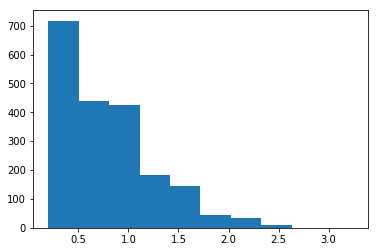

In [160]:
plt.hist(df['carat']);

### Price Distribution

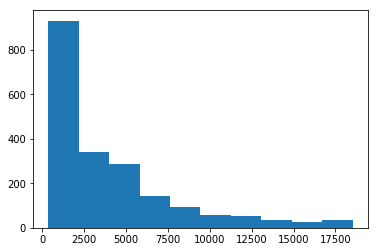

In [161]:
plt.hist(df['price']);

## Feature Relationship

### Carat vs x

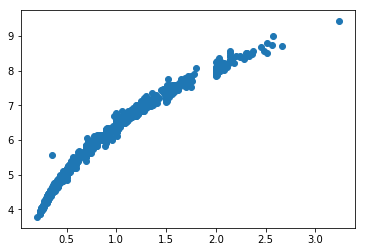

In [162]:
plt.scatter(df['carat'], df['x']);

### Carat vs y

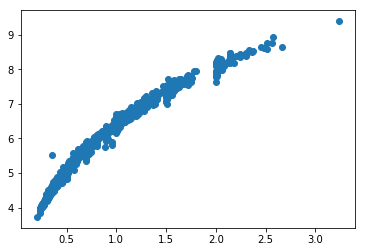

In [163]:
plt.scatter(df['carat'], df['y']);

### Carat vs z

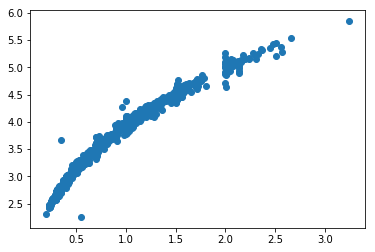

In [164]:
plt.scatter(df['carat'], df['z']);

## Feature-Target Plots

### Carat vs Price

Text(0,0.5,'Price ($)')

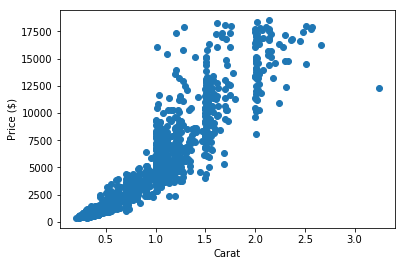

In [165]:
plt.scatter(df['carat'], df['price'])
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# Pre-processing

## Categorical Data

### One-Hot Encoding

In [166]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
49,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
66,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
79,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
120,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
188,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Oridnal

In [167]:
X_cat_ord = X_cat.copy()

In [168]:
cut_ord = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_ord = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_ord = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
ord_list = [cut_ord, color_ord, clarity_ord]

In [169]:
# replace string feature labels with ordinal values
for i, column in enumerate(X_cat_ord.columns):
    
    # create label dictionary for each categorical feature
    label_dict = {}
    for j, label in enumerate(ord_list[i]):
        # map each label to ordinal value
        label_dict[label] = j
    
    # replace feature labels with ordinal values
    X_cat_ord[column] = X_cat_ord[column].map(label_dict)

In [170]:
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


In [171]:
X_cat_ord.head()

,cut,color,clarity
49,2,5,3
66,4,3,5
79,2,6,5
120,4,4,1
188,3,4,3


## Combine Numerical and Categorical Features

In [172]:
X = pd.concat([X_num, X_cat_enc], axis=1)
X.head()

,carat,depth,table,x,y,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
49,0.25,63.3,60.0,4.00,4.03,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
66,0.28,61.4,56.0,4.19,4.22,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
79,0.26,62.8,60.0,4.01,4.05,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
120,0.80,59.9,59.0,6.01,6.07,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
188,0.71,62.1,58.0,5.67,5.70,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Test/Train Split

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Normalize Data

In [174]:
norm_scaler = MinMaxScaler()
X_train_norm = norm_scaler.fit_transform(X_train)
X_test_norm = norm_scaler.transform(X_test)

# Modeling

In [175]:
lin_reg = LinearRegression()

In [176]:
lin_reg.fit(X_train_norm, y_train)
lin_reg.score(X_train_norm, y_train)

0.9311490349026535

## Cross-validation

In [177]:
np.mean(cross_val_score(lin_reg, X_train_norm, y_train, cv=10))

0.9261095731307059

## Evaluation

In [178]:
lin_reg.score(X_test_norm, y_test)

0.9054174116393325

### Accuracy

In [179]:
predictions = lin_reg.predict(X_test_norm)

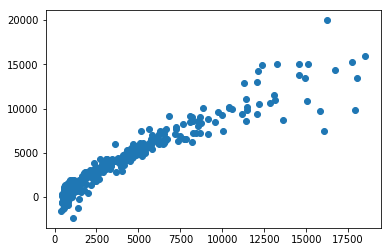

In [180]:
plt.scatter(y_test, predictions);

### Residuals

In [181]:
residuals = y_test - predictions

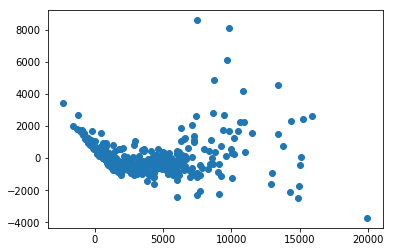

In [182]:
plt.scatter(predictions, residuals);

### Q-Q Plot

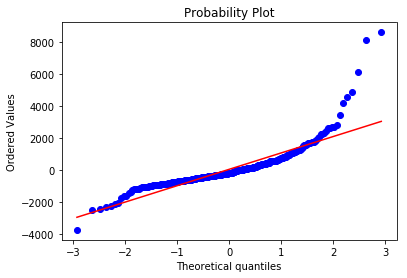

In [183]:
stats.probplot(residuals, dist="norm", plot=plt);

# Model Refinement

## Log Transform of Feature Variable
Transform feature with apparent log-normal distribution to log scale.

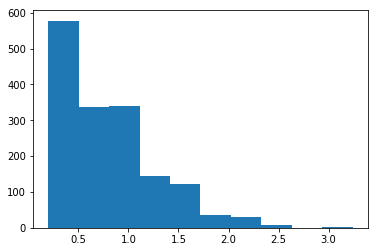

In [184]:
plt.hist(X_train['carat']);

In [185]:
X_train_ln = X_train.copy()
X_train_ln['carat'] = X_train_ln['carat'].apply(np.log)
X_test_ln = X_test.copy()
X_test_ln['carat'] = X_test_ln['carat'].apply(np.log)

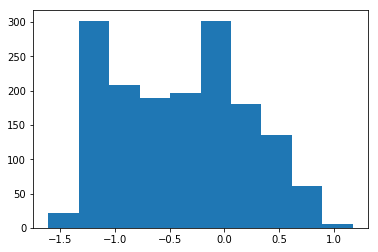

In [186]:
plt.hist(X_train_ln['carat']);

In [187]:
lin_reg.fit(X_train_ln, y_train)
lin_reg.score(X_train_ln, y_train)

0.9277634876512848

In [188]:
np.mean(cross_val_score(lin_reg, X_train_ln, y_train, cv=10))

0.9240986328061174

In [189]:
lin_reg.score(X_test_ln, y_test)

0.8454295900847659

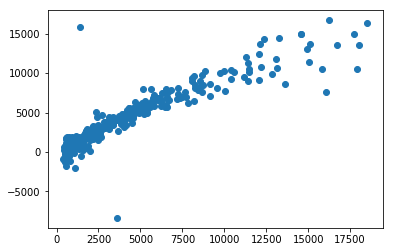

In [190]:
predictions = lin_reg.predict(X_test_ln)
plt.scatter(y_test, predictions);

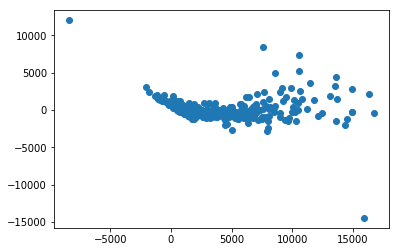

In [191]:
residuals = y_test - predictions
plt.scatter(predictions, residuals);

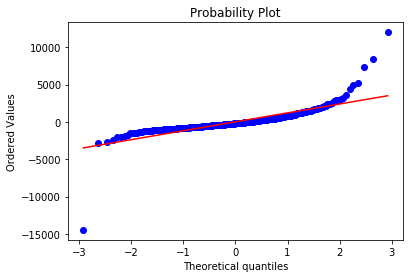

In [192]:
stats.probplot(residuals, dist="norm", plot=plt);

## Log Transform of Target Variable
Transform target variable with apparent log-normal distribution to log scale.

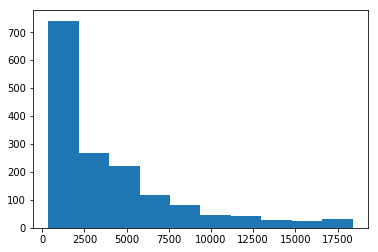

In [193]:
plt.hist(y_train);

In [194]:
y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)

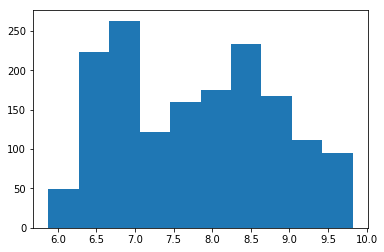

In [195]:
plt.hist(y_train_ln);

In [196]:
lin_reg.fit(X_train_norm, y_train_ln)
lin_reg.score(X_train_norm, y_train_ln)

0.9838526994234724

In [197]:
np.mean(cross_val_score(lin_reg, X_train_norm, y_train_ln, cv=10))

0.9831627725007346

In [198]:
lin_reg.score(X_test_norm, y_test_ln)

0.9738929332263593

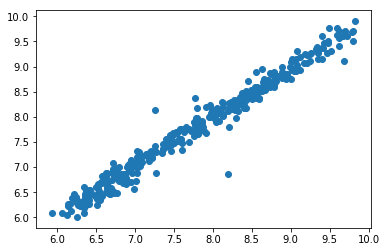

In [199]:
predictions = lin_reg.predict(X_test_norm)
plt.scatter(y_test_ln, predictions);

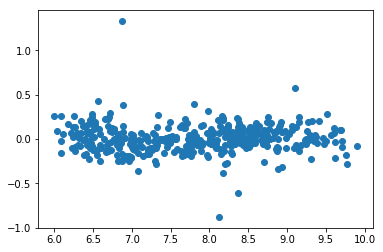

In [200]:
residuals = y_test_ln - predictions
plt.scatter(predictions, residuals);

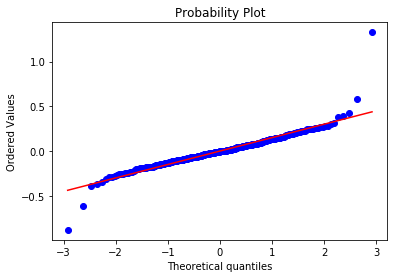

In [201]:
stats.probplot(residuals, dist="norm", plot=plt);

## Polynomial Transformation of Feature Variables
Transform feature data to polynomial features so that it is better able to fit the training data.

In [202]:
poly = PolynomialFeatures(degree=3)
X_train_norm_poly = poly.fit_transform(X_train_norm)
X_test_norm_poly = poly.transform(X_test_norm)

In [203]:
lin_reg.fit(X_train_norm_poly, y_train)
lin_reg.score(X_train_norm_poly, y_train)

0.9951377529323292

In [204]:
cross_val_score(lin_reg, X_train_norm_poly, y_train, cv=10)

array([-1.51684703e+16, -4.03425119e+16, -9.30990099e+13, -3.83445723e+16,
       -7.96355226e+15, -2.06715291e+12, -1.63058861e+16, -1.61522951e+17,
       -5.21902174e+17, -3.63333452e+13])

In [205]:
lin_reg.score(X_test_norm_poly, y_test)

-11710685586632.078

## Regularization
Regularization is needed due to test score << training score.

In [206]:
alpha_range = np.linspace(0.001, 10, 10)

In [207]:
LR_ridge = linear_model.RidgeCV(alphas=alpha_range, cv=10, scoring='r2')
LR_ridge.fit(X_train_norm_poly, y_train)
LR_ridge.score(X_train_norm_poly, y_train)

0.9825644733563605

In [208]:
LR_ridge.alpha_

1.1119999999999999

In [209]:
LR_ridge.score(X_test_norm_poly, y_test)

0.9588320791738943

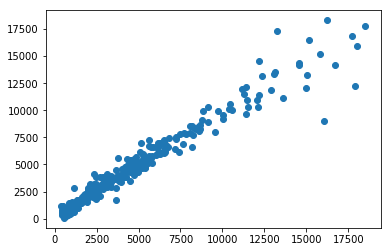

In [210]:
predictions = LR_ridge.predict(X_test_norm_poly)
plt.scatter(y_test, predictions);

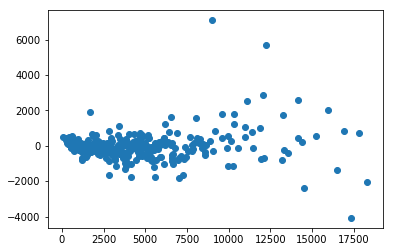

In [211]:
residuals = y_test - predictions
plt.scatter(predictions, residuals);

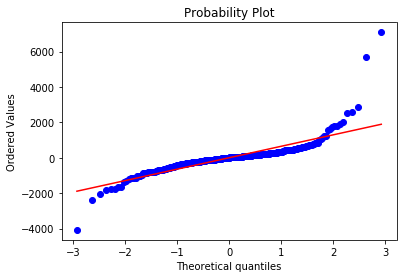

In [212]:
stats.probplot(residuals, dist="norm", plot=plt);

# Final Model
Combine polynomial features and target transformed to log scale for final model.

In [213]:
lin_reg.fit(X_train_norm_poly, y_train_ln)
lin_reg.score(X_train_norm_poly, y_train_ln)

0.996728978817453

In [214]:
cross_val_score(lin_reg, X_train_norm_poly, y_train_ln, cv=10)

array([-2.03772999e+15, -1.11146217e+16, -4.26148125e+15, -1.86451993e+14,
       -2.90058730e+15, -7.57855488e+15, -1.07750555e+16, -1.00022996e+17,
       -6.44715565e+17, -1.42703457e+16])

In [215]:
lin_reg.score(X_test_norm_poly, y_test_ln)

-416231363196872.94

## Regularization

In [246]:
alpha_range = np.linspace(0.001, 10, 10)

In [247]:
LR_ridge = linear_model.RidgeCV(alphas=alpha_range, cv=10, scoring='r2')
LR_ridge.fit(X_train_norm_poly, y_train_ln)
LR_ridge.score(X_train_norm_poly, y_train_ln)

0.989691630720694

In [248]:
LR_ridge.score(X_test_norm_poly, y_test_ln)

0.9813590563501815

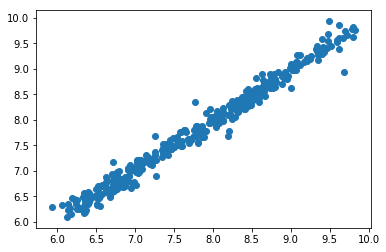

In [263]:
predictions = LR_ridge.predict(X_test_norm_poly)
plt.scatter(y_test_ln, predictions);

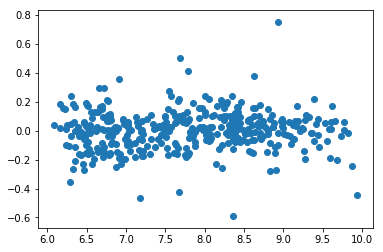

In [264]:
residuals = y_test_ln - predictions
plt.scatter(predictions, residuals);

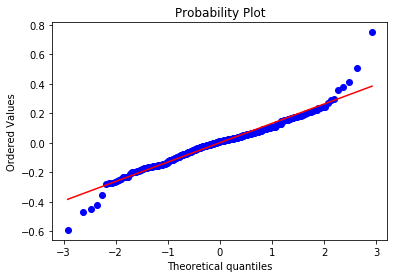

In [265]:
stats.probplot(residuals, dist="norm", plot=plt);

In [259]:
# transform model predictions back to normal scale
predictions = np.exp(LR_ridge.predict(X_test_norm_poly))

In [222]:
from sklearn.pipeline import Pipeline

In [295]:
lin_reg_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())])

In [296]:
lin_reg_pipe.fit(X_train_ln, y_train_ln)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [297]:
lin_reg_pipe.score(X_train_ln, y_train_ln)

0.984480319934861

In [298]:
np.mean(cross_val_score(lin_reg_pipe, X_train_ln, y_train_ln, cv=10))

0.9837628801264444

In [299]:
lin_reg_pipe.score(X_test_ln, y_test_ln)

0.978439191108726

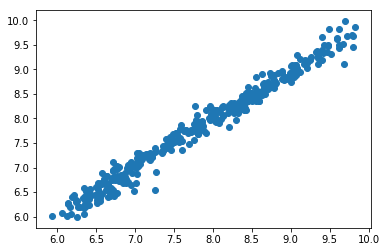

In [301]:
predictions = lin_reg_pipe.predict(X_test_ln)
plt.scatter(y_test_ln, predictions);

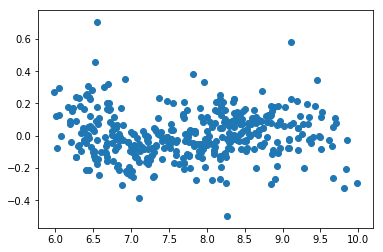

In [302]:
residuals = y_test_ln - predictions
plt.scatter(predictions, residuals);

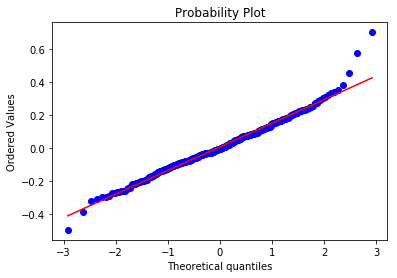

In [303]:
stats.probplot(residuals, dist="norm", plot=plt);

# Model Interpretation

## Feature Selection

In [271]:
feat_selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k='all')
feat_selector.fit(X_train_norm, y_train_ln)

SelectKBest(k='all', score_func=<function f_regression at 0x7fcac0116bf8>)

In [272]:
feat_selector.scores_

array([9.61654054e+03, 4.93115529e+00, 4.37870631e+01, 2.06455987e+04,
       2.09492602e+04, 4.96651738e-01, 1.91892492e-01, 9.54151768e+00,
       2.96779018e+00, 1.57623620e+00, 6.15373825e+00, 1.40390895e+01,
       2.85342456e+00, 5.43207282e-02, 9.14345252e+00, 1.19579300e+01,
       1.36756834e+01, 1.91173827e+00, 1.05103767e+01, 1.98808675e+00,
       9.04744206e+01, 2.44321716e+00, 4.01776812e+00, 2.53832185e+01,
       1.36126811e+01])

In [276]:
pd.DataFrame(feat_selector.scores_, index=X.columns, columns=['Feature Score'])

,Feature Score
carat,9616.540543
depth,4.931155
table,43.787063
x,20645.598677
y,20949.260157
cut_Fair,0.496652
cut_Good,0.191892
cut_Ideal,9.541518
cut_Premium,2.967790
cut_Very Good,1.576236


## Coefficients

In [286]:
LR_ridge.coef_

array([0.        , 0.42315414, 0.06976633, ..., 0.        , 0.        ,
       0.01312545])